In this Python notebook, we will implement an acoustic modem that transmit bits between computers using the speaker in the transmitter and the microphone in the receiver. The system is for the most part based on the diagram below.

<img src="baseband_system.png" ,width="800">

This is how the variables in the code map into the signals in the diagram:

-  $a_k$ is the array `bit`
-  $p(t)$ is the array `pulse`
-  $h(t)$ is also `pulse`
-  $y(t)$ is the array `filtered`

The channel and noise are kindly provided by the actual acoustic system between the speaker and the microphone, so there are no corresponding variables in the code.

Sadly, the speakers do not transmit low frequencies, so we will still have to modulate $m(t)$ to higher frequencies. The modulator and demodulator are not shown. Because of that, this is a fake-baseband modem.

First we load the required packages and define the function for the root-raised-cosine pulse. This function was taken verbatim from https://github.com/muccc/iridium-toolkit/blob/master/extractor-python/filters.py

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import soundfile as sf
%matplotlib inline
plt.rcParams['figure.figsize'] = [15,10]
plt.rc('text', usetex=True)
plt.rc('font', size=20)
plt.rc('font', family='serif')

In [64]:
def rrcosfilter(N, alpha, Ts, Fs):
    """
    Generates a root raised cosine (RRC) filter (FIR) impulse response.
    
    Parameters
    ----------
    N : int 
        Length of the filter in samples.
    
    alpha: float
        Roll off factor (Valid values are [0, 1]).
    
    Ts : float
        Symbol period in seconds.
    
    Fs : float 
        Sampling Rate in Hz.
    
    Returns
    ---------
    h_rrc : 1-D ndarray of floats
        Impulse response of the root raised cosine filter.
    
    time_idx : 1-D ndarray of floats 
        Array containing the time indices, in seconds, for 
        the impulse response.
        
    """

    T_delta = 1/float(Fs)
    time_idx = ((np.arange(N)-N/2))*T_delta
    sample_num = np.arange(N)
    h_rrc = np.zeros(N, dtype=float)
        
    for x in sample_num:
        t = (x-N/2)*T_delta
        if t == 0.0:
            h_rrc[x] = 1.0 - alpha + (4*alpha/np.pi)
        elif alpha != 0 and np.abs(t - Ts/(4*alpha)) < 1e-15:
            h_rrc[x] = (alpha/np.sqrt(2))*(((1+2/np.pi)* \
                    (np.sin(np.pi/(4*alpha)))) + ((1-2/np.pi)*(np.cos(np.pi/(4*alpha)))))
        elif alpha != 0 and np.abs(t + Ts/(4*alpha)) < 1e-15:
            h_rrc[x] = (alpha/np.sqrt(2))*(((1+2/np.pi)* \
                    (np.sin(np.pi/(4*alpha)))) + ((1-2/np.pi)*(np.cos(np.pi/(4*alpha)))))
        else:
            h_rrc[x] = (np.sin(np.pi*t*(1-alpha)/Ts) +  \
                    4*alpha*(t/Ts)*np.cos(np.pi*t*(1+alpha)/Ts))/ \
                    (np.pi*t*(1-(4*alpha*t/Ts)*(4*alpha*t/Ts))/Ts)

    return time_idx, h_rrc

Next, we generate the bits to be transmitted and the PAM-modulated signal. 

$f_s$ is the sampling rate for the modulated signal. This is what will be transmitted and recorded, so it is best if the sampling rate is something used by most recording software. Traditional rates are 22050, 44100, or 48000. 

upsample is the number of samples of the modulated signal between two consecutive symbols. The symbol rate is, thus, $R_s = f_s/$`upsample`

r is the roll-off factor of the root-raised cosine

L is the length of the pulse, in symbol periods

The array `bit_u` contains the upsampled symbols. It has the symbol values at the beginning of each symbol period, and `upsample-1` zeros in-between. This ensures that the convolution of `bits_u` and the pulse will generate, every `upsample` instants, a shifted copy of the pulse multiplied by the appropriate symbol.

In [3]:
#from commpy.filters import rrcosfilter

upsample = 100
#Number of symbols
Ns = 1000
#Sampling frequency
fs = 22050
Rb = fs/upsample
#Roll-off factor
r = 0.1
#Length of pulse, in multiples of the symbol period
L = 11

#Generate random symbols
np.random.seed(0)
bit = 2*np.random.randint(0,2,Ns)-1
t1,pulse = rrcosfilter(L*upsample,r,1/Rb,fs)

#Upconvert symbol sequence
bit_u = np.zeros(Ns*upsample)
bit_u[::upsample] = bit

#Generate channel input m(t)
PAM = np.convolve(bit_u,pulse)

First, we see that the power spectral density of the PAM signal is contained to $|f| < (1+r)R_b/2$, as expected

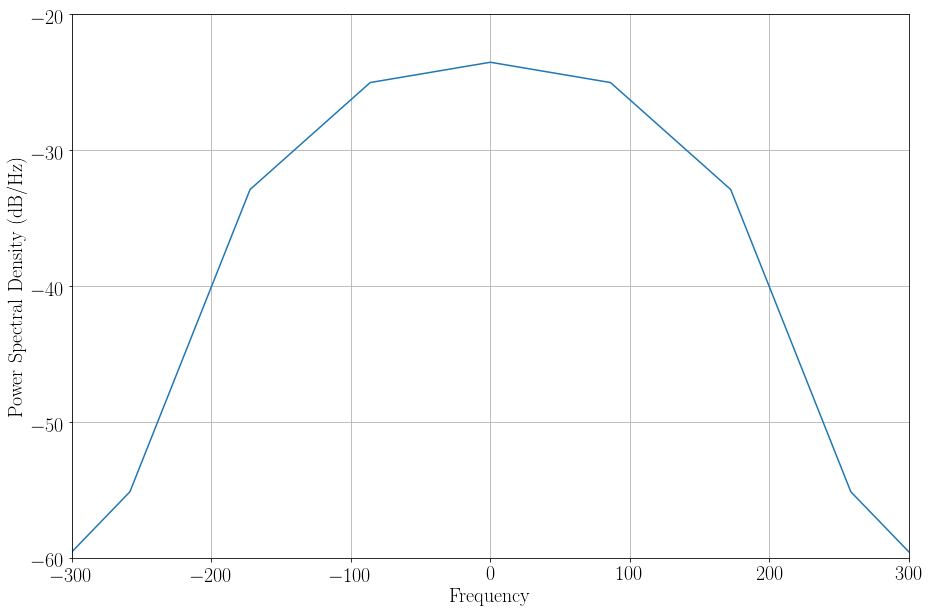

In [31]:
Pss,freq = plt.psd(PAM,Fs = fs,detrend=plt.mlab.detrend_none,sides='twosided')
plt.xlim([-300,300])
plt.ylim([-60,-20])
plt.show()

Let us then look at the PAM signal in the time domain. Note that, at the instants when a bit is transmitted (the red $\times$ in the figure) the transmitted signals does not coincide with the bits. This is because the shaping pulse does not satisfy the Nyquist criterion. This will be fixed when the transmitted signal goes through the receive filter, also a root-raised-cosine. After the receive filter, the symbols will be shaped by the convolution of the pulse and the receive filter, which does satisfy the Nyquist criterion.

In the plot below, the dashed lines show the pulse that correspond to each of the first 10 symbols. The solid, thicker line is the transmitted signal, and corresponds to the sum of all the dashed lines, plus many other lines that are not shown in the figure, for bits 11 on. 

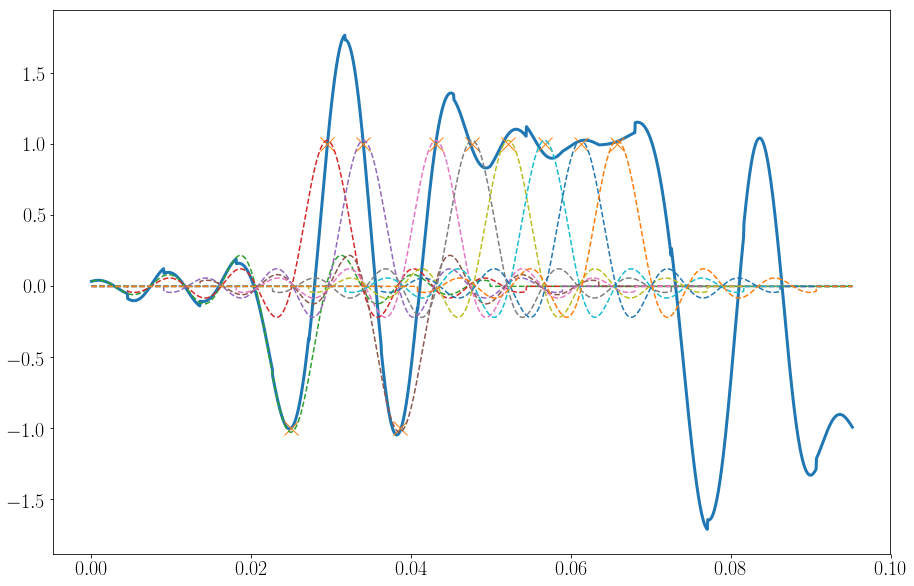

In [8]:
Nbits_show = 10
Nsamples_show = Nbits_show*upsample + pulse.size
t = np.arange(Nsamples_show)/fs
plt.plot(t[:Nsamples_show],PAM[:Nsamples_show],linewidth = 3)
Tbit = np.arange(Nbits_show)/Rb + pulse.size/fs/2
plt.plot(Tbit,bit[:Nbits_show],'x',markersize = 14);
for ii in range(Nbits_show):
    teste = np.zeros(Nsamples_show)
    teste[ii*upsample] = bit[ii]
    plt.plot(t,np.convolve(teste,pulse)[:Nsamples_show],'--')

There is something weird going on. Notice the jumps on the plot above. This happens because we chose a pulse duration that is too short. In the plot of the pulse below we can see that the pulse hasn't tapered enough, the outermost samples are still not neglogible.

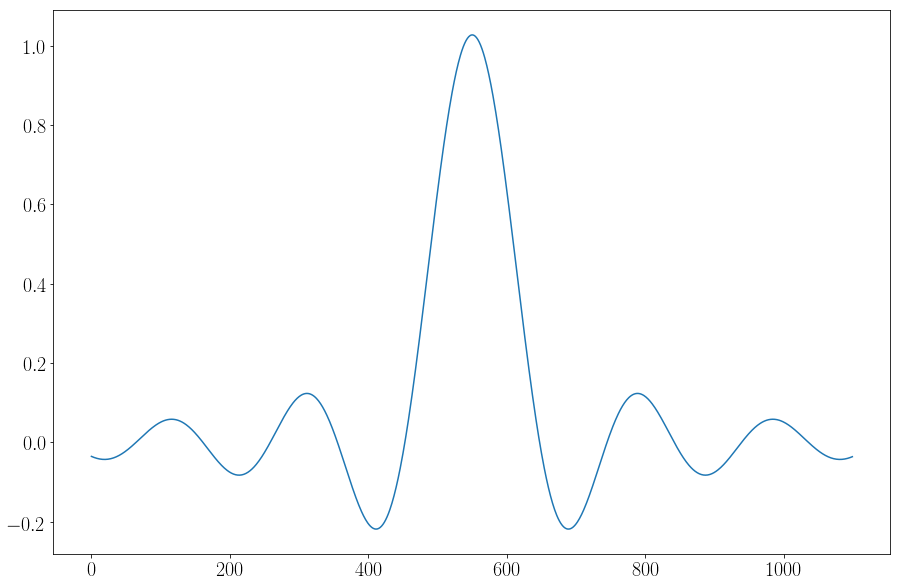

In [16]:
plt.plot(pulse);

The main consequence of using too few samples in the pulse is that the convolution of the pulse with itself no longer satisfies the Nyquist criterion. To see this, we pass the PAM signal through the receive filter, generating the filtered signal $y(t)$ in the diagram. We then plot its eye diagram.

The eye diagram divides the signal in non-overlapping intervals with the duration of the symbol period, and plots each interval on the same graph. As a result, points in the curves with the same value on the x axis of the eye diagram correspond to samples of the filtered signal separated by multiples of $R_b$.

The main point of this plot is this: since we will sample the filter output with a rate $R_b$, this means that each the samples of the filtered signal all appear at the same point in the x axis of the eye diagram. 

Notice that, in practice, we do not know exactly when to sample, so we just choose a random portion of the filtered signal to plot the eye diagram.

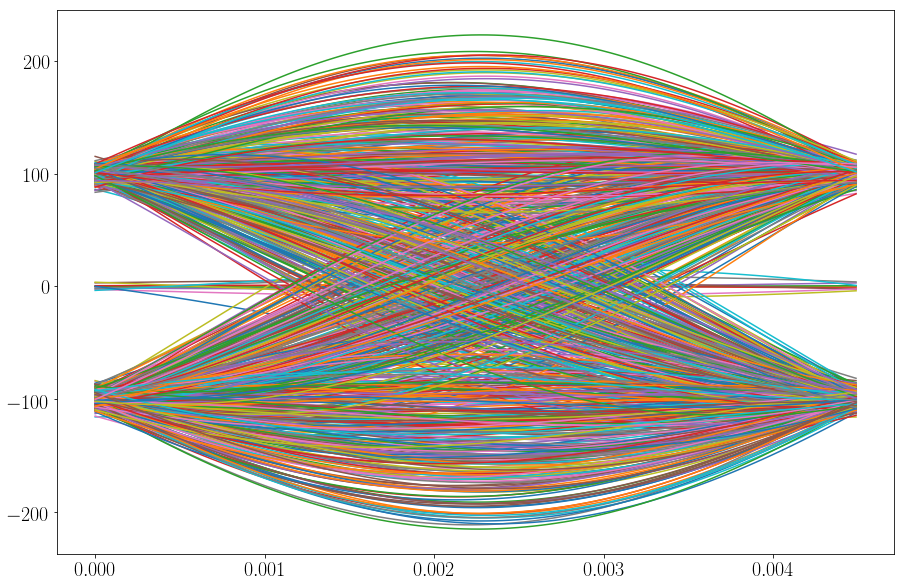

In [8]:
t = np.arange(upsample)/fs
filtered = np.convolve(PAM, pulse)
eye = filtered[:Ns*upsample].reshape(upsample,Ns,order='F');
plt.plot(t,eye);

If the pulse were indeed root-Nyquist, there would be a sampling instant where the filtered signal would depend only on the transmitted symbol, and nothing else. In other words, if the pulse were root-Nyquist, at the sampling instants the filtered signal could only take on one of two values: $\pm 1$. Clearly there is no such point in the diagram below, indicating that the convolution of the pulse with itself is not Nyquist.

To fix this, we can either increase the interval of the roll-off factor. Let's do the latter, to keep things with low memory requirement.

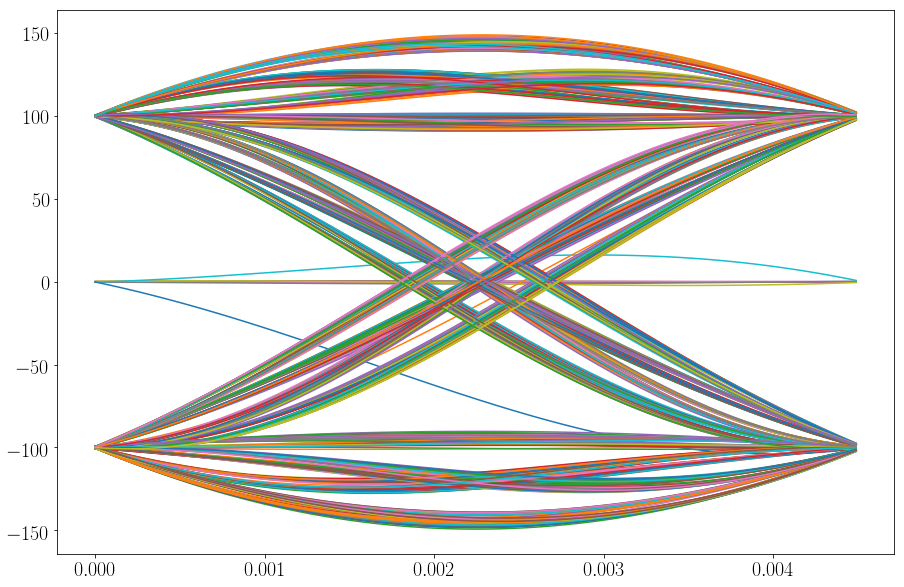

In [41]:
r = 0.5
t1,pulse = rrcosfilter(L*upsample,r,1/Rb,fs)
PAM = np.convolve(bit_u,pulse)
filtered = np.convolve(PAM,pulse)
eye = filtered[:Ns*upsample].reshape(upsample,Ns,order='F');
plt.plot(t,eye);

Problem solved, now all the samples at the beginning of the interval (other than some rogue lines) are either $-1$ or $1$. We have just seen one problem with using too small a value for $r$: we need long pulses to make that work.

The second problem with small values of $r$ can also be seen in the plots above. For $r = 0.1$, note how the eye is closed after 1ms. This means that if we sample with an error of 1ms, instead of sampling at the optimal instant, the eye will be closed. This in turn means that there is so much interference from the other symbols that we might as well take random guesses on what symbol was transmitted. And this would still happen even if we use a pulse that is long enough to ensure that the convolution of the pulse with itself satisfies the Nyquist criterion.

For $r = 0.5$, the eye is still open after 1ms. This means that, for this value of $r$, a sampling error of 1ms is manageable. It is obviously not desired, but the system will still be able to function provided that the noise is not too large. 

Before we move on, why are there some rogue lines in the middle of the eye? We started plotting the eye using the first samples of the filtered signal, where we have only the leading samples of the first pulse. 

Also notice that the ideal sampling instant is at the start of the eye diagram: that is when the filtered signal is exactly equal to the symbols. This happened by coincidence, there is no reason why this should happen when the first sample of the filtered signal used to build the eye diagram is chosen randomly.

Another problem for the acoustic modem: the channel is not baseband, the speakers and microphones do not respond to low frequencies. Indeed, if you play the signal `PAM`, chances are you will hear nothing. We thus have to modulate the PAM signal to a passband frequency. For the audio equipment I had in hand, modulating to $f_c = 4500$Hz is a good choice.

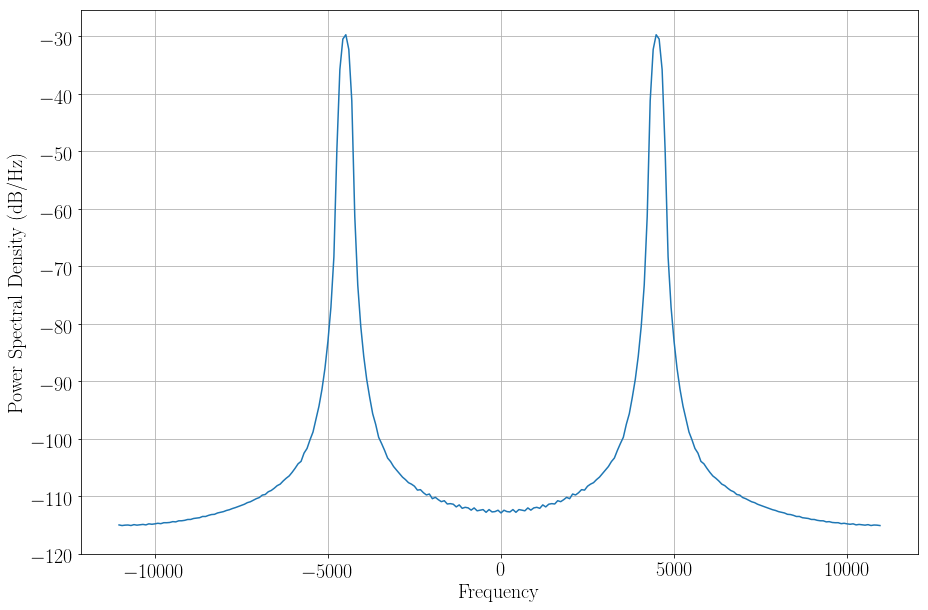

In [44]:
t = np.arange(PAM.size)/fs
modulated = PAM * np.cos(2*np.pi*4500*t)
Pss,freq = plt.psd(modulated,Fs = fs,detrend=plt.mlab.detrend_none,sides='twosided')
#plt.xlim([-2000,2000])
plt.show();

We will now do three things that are unusual for passband transmission

-  In a practical system, we would transmit also in quadrature, modulating another sequence of bits using a sine waveform.

-  In a practical system, we would have to worry about the frequency and, perhaps more critically, the phase of the carrier. Here, we will pay no attention to this, instead just hoping for the best.

- We will use the Hilbert transform to demodulate. If you do not know what that is, don't worry, just know that it will help in the demodulation.

The idea is to focus on the baseband part of the system, without delving too much on the details of passband transmission. Please do not worry about this too much at this point, we will see that in more detail in the passband modem. 

We are now ready to write the modulated signal to an audio file, which should then be played in a computer, and recorded in another. Make sure to record the signal using the same sampling rate used to generate the modulated signal. I named the recorded file rec1.wav

In [46]:
sf.write('tx.wav', modulated, fs)

We then play this file on a cellphone and record it in another. To make things less noisy, we actually connected the earphone plug of the cell phone to the microphone jack of a computer using a p2-p2 cable. Notice also that we reload the transmitted signal. This is so that we can start running the code from this point, without having to generate the modulated signal over and over.

In [70]:
received1, fs = sf.read('rx.wav')
modulated, fs = sf.read('tx.wav')

To keep processing faster, let us first trim the recorded signal, eliminating the silent times before and after the actual transmission.

In [74]:
received = received1[27000:133000]

Now, let's look at the recceived signal in the frequency domain, where interesting things can be seen.

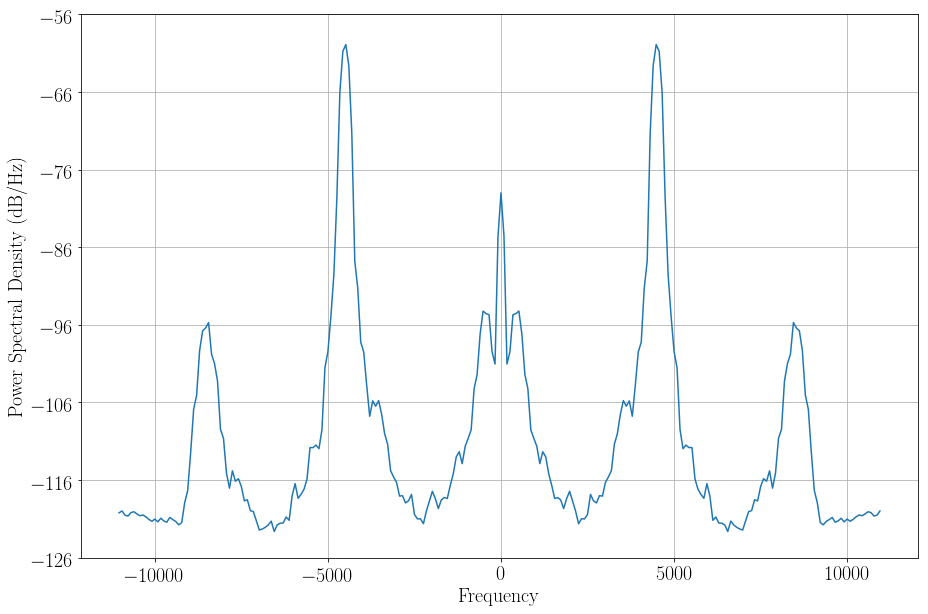

In [75]:
Pss,freq = plt.psd(received,Fs = fs,detrend=plt.mlab.detrend_none,sides='twosided')
plt.show();

How come there are frequencies at baseband and at around 9kHz, considering that the transmitted signal only had frequencies around 4.5kHz? Clearly, the channel, which again consists of the speaker and microphone, cannot be modeled as a linear and time invariant system, otherwise the recorded signal would contain exactly the same frequencies that were present in the transmitted signal.

The main culprit here is probably a non-linearity, perhaps due to some saturation. Indeed, you should convince yourself that the behavior observed in the figure above looks a lot like squaring the modulated PAM signal. Squaring in time corresponds to convolution in frequency, and convolving the modulated PAM signal with itself produces exactly components in baseband and at 9kHz.

This non-linearity is the main reason why we chose the rather small symbol rate of $R_b = 220.5$ symbols/s. If the rate were much larger, the non-linearity would cause low frequencies of the modulated signal to interfere with its higher frequencies. As a bonus, we can be more confident that the channel response (at least its linear part) will be flat in the frequency band of the signal, which allows us to ignore the channel.

Assuming we chose $R_b$ small enough, we will then move on as if the channel were linear, since the receive filter will eliminate the undesired frequencies created by the non-linearities.

We must first demodulate the signal back to baseband, I will use the Hilbert transform for that. The main reason is that multiplying by a cosine, as would be more usual in a continuous time system, would double the frequency, which can result in frequencies above the Nyquist rate. (The Nyquist rate here is the one in the sampling theorem: half the sampling rate.)

The attentive reader will notice that I paid no attention to the phase of the carrier, instead hoping that all will turn out fine. If you are bothered by this, or if you have no idea what I am talking about, don't worry: we'll get to that when we discuss the passband modem in more detail.

In [76]:
t2 = np.arange(received.size)/fs
demodulate = np.real(signal.hilbert(received)*np.exp(-1j*2*np.pi*4500*t2))
#demodula = recebido*np.cos(2*np.pi*4500*t2)
filtered = np.convolve(demodulate,pulse)

Let us now look at the filtered signal in the frequency domain, where we see that things make sense: we only have the baseband frequencies. We still see a bit of the frequencies due to the non-linearities, but they have been greatly attenuated.

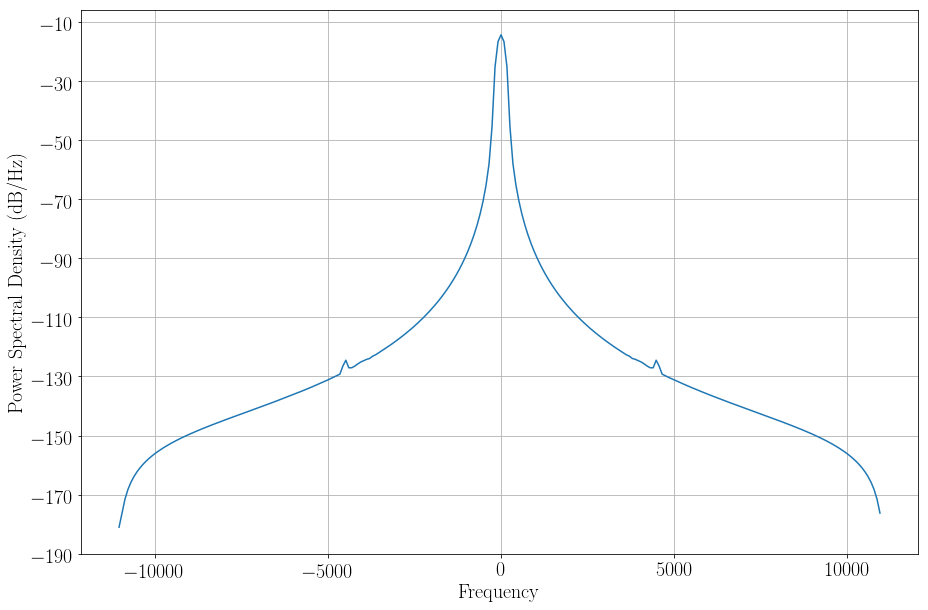

In [77]:
Pss,freq = plt.psd(filtered,Fs = fs,detrend=plt.mlab.detrend_none,sides='twosided')
plt.show();

Now we look at the filtered signal in the time domain. 

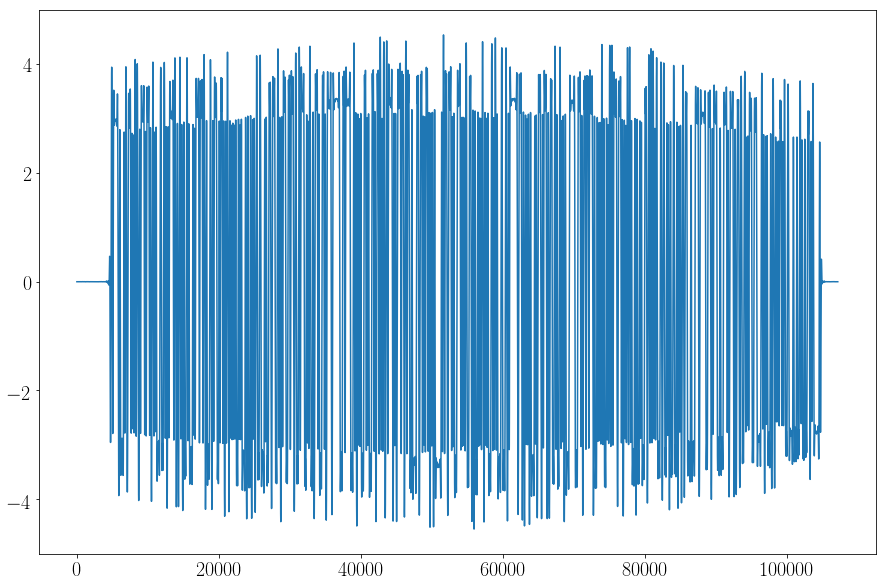

In [78]:
plt.plot(filtered);

How does that look? To begin with, the amplitude seems to change slightly with time. I am, for the moment, guessing that this is due to some synchronization problem with the carrier. 

Other than that, to begin the analysis, let's look at the eye diagram using samples from 20000 to 100000.

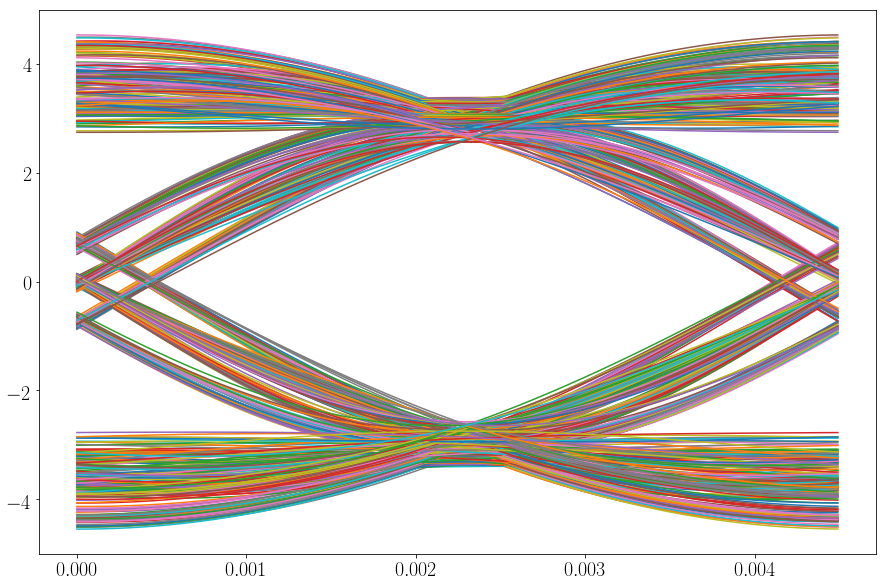

In [79]:
t = np.arange(upsample)/fs
begin = 20000
Ns_show = 800
eye = filtered[begin:begin+Ns_show*upsample].reshape(upsample,Ns_show,order='F');
plt.plot(t,eye);

Not perfect, but we can clearly see an eye. Things look hopeful. We now have to make our decisions, estimating the transmitted bits by sampling the filtered signal at a rate $R_b$, or, in the discrete-time domain, every `upsample` samples. The question is: where do we begin this sampling process? 

In practice, every transmission begins with a series of synchronization symbols, which are known to both the transmitter and the receiver. The receiver then compares the received signal to what it expects to see when the synchronization symbols are transmitted. If it finds that an interval in the received signal is enough of a match, it declares that a transmission has begun at that instant. 

Here, we will cheat and assume that, as far as synchronization is concerned, all the transmitted symbols are known. The comparison between what we actually received to what we expected to receive will be based on the correlation between the signals. Also, we will compare the actual and expected signals at the output of the receive filter.

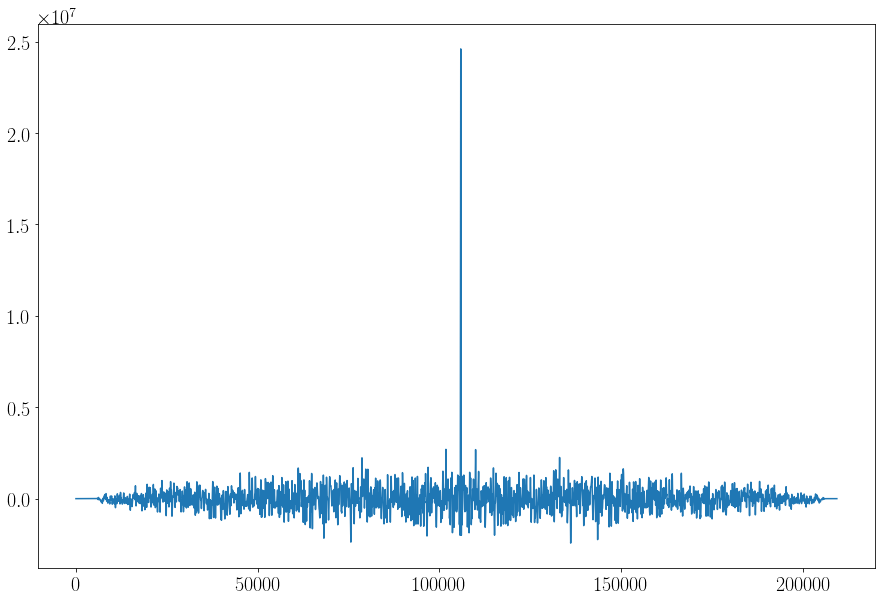

In [93]:
t2 = np.arange(modulated.size)/fs
demodulate1 = np.real(signal.hilbert(modulated)*np.exp(-1j*2*np.pi*4500*t2))
filtered1 = np.convolve(demodulate1,pulse)
synch = np.correlate(filtered,filtered1,mode='full')
delay = np.abs(synch).argmax()
plt.plot(synch);

Great, we have one clear peak, indicating that the correlation is large at a single point. Actually, the peak is not as sharp as it seems, it is just a matter of scale. To see this, let's zoom in around the peak.

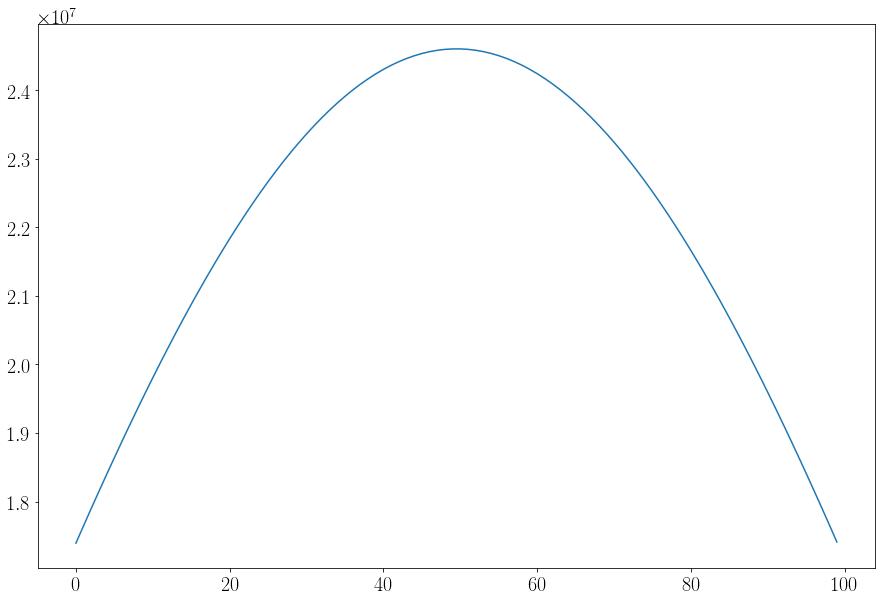

In [94]:
plt.plot(np.abs(synch[delay-50:delay+50]));

Not too sharp, but good enough. We are interested in the beginning of the overlap with maximum correlation, but in Python the index in the correlation output corresponds to the moment when the overlap ends. We fix this and, to highlight the high correlation, we plot both filtered and the expected filtered signals. The signals have different amplitudes, so we normalize one of them to make the graphs comparable.

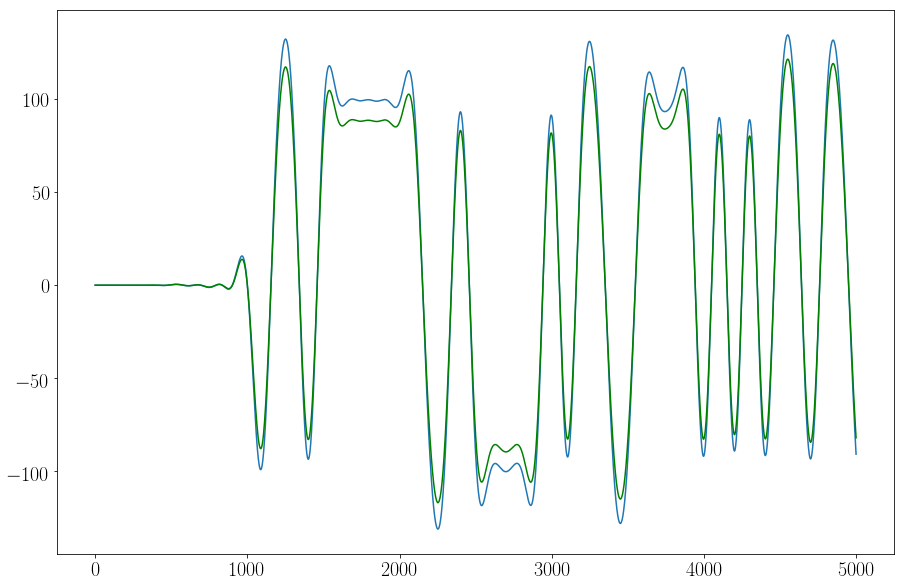

In [96]:
d = delay - filtered1.size
plt.plot(filtered1[:5000]);
plt.plot(filtered[d:d+5000]*filtered1.max()/filtered.max(),'g');

Looks like a good match to me. Let's sample and compute how many bits were correctly detected. Note that the actual sampling insant is not at the beginning of the plot above, which actually coincides with the beginning of the transmission of the first symbol, which modulates the convolution of the shaping pulse with the receive filter. The actual sampling instant should be at the middle of this convolved pulse.

In [109]:
final_d = d + pulse.size
bits_ = filtered[final_d:final_d + upsample*Ns:upsample]
np.abs(bit-np.sign(bits_)).sum()

0.0

Not bad, no errors!

The next plots are not directly related to the baseband modem aiming, instead, at illustrating some concepts in more detail. The next two plots, for instance, illustrate why the symbols to be transmitted are placed once every `upsample` samples at the input of the shaping filter. First, we show what we want in continuous time: the pulses generated by symbols $a_0$ and $a_1$ should be separated by $T_b$ seconds. 

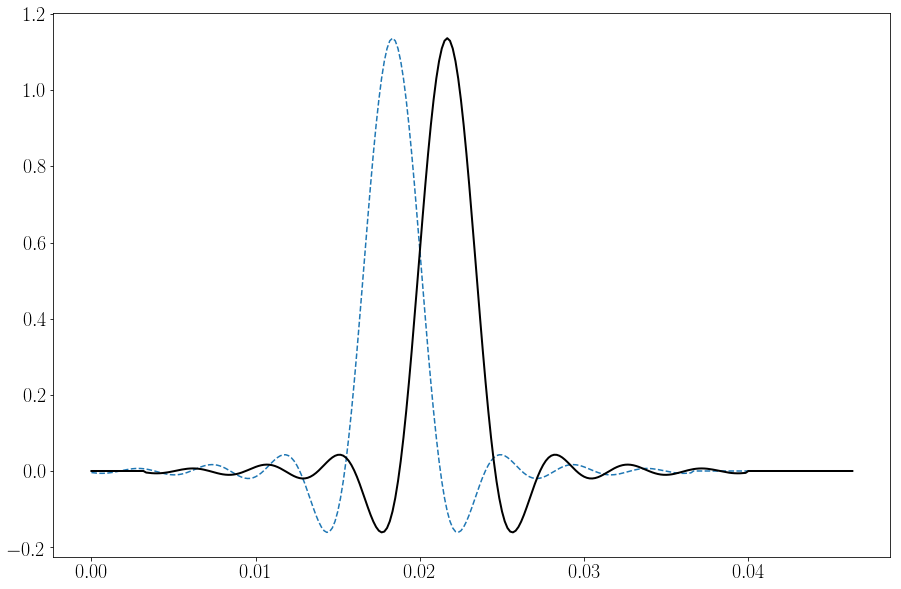

In [67]:
fs1 = 6000
upsample1 = 20
Rb1 = fs1/upsample1
r = 0.5

t1,pulse1 = rrcosfilter(11*upsample1,r,1/Rb1,fs1)

teste = np.zeros(3*upsample1)
teste[0] = 1
teste1 = np.convolve(teste,pulse1)
t = np.arange(teste1.size)/fs1
plt.plot(t,teste1,'--');

teste = np.zeros(3*upsample1)
teste[upsample1] = 1
teste1 = np.convolve(teste,pulse1)
t = np.arange(teste1.size)/fs1
plt.plot(t,teste1,'k',linewidth=2);


Next, we show a plot of the discrete-time shaping filter output. These are the samples that are fed to a Digital-to-Analog Converter (DAC), whose output should be equal to the previous plot, which shows the continuous-time signal. According to the sampling theorem, if the signal is sampled fast enough, we can guarantee that the output of the DAC will be equal to the desired continous-time signal as long as the discrete-time signal is a sampled version of the continuous-time signal.

Well, the sampling frequency we are using is $f_s$, which means that two adjacent samples will be placed $T_s = 1/f_s$ seconds apart. Thus, if we want the pulses to be shifted by $T_b$ seconds, we should insert $T_b/T_s$ samples between them. This is exactly how `upsample`is computed. Actually, we need to ensure that $T_b/T_s$ is an integer, since we can only insert an integer number of samples between the symbols. Thus, in this code, we first chose `upsample` and $f_s$, and then we computed $R_b = $ `upsample` $/f_s$.

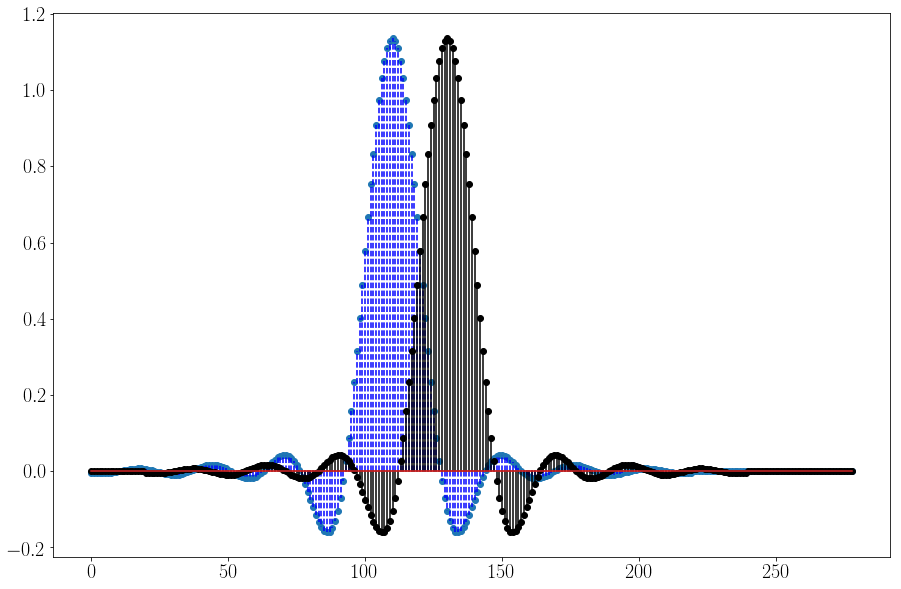

In [70]:
fs1 = 6000
upsample1 = 20
Rb1 = fs1/upsample1

t1,pulse1 = rrcosfilter(11*upsample1,r,1/Rb1,fs1)

teste = np.zeros(3*upsample1)
teste[0] = 1
teste1 = np.convolve(teste,pulse1)
plt.stem(teste1,'b--');

teste = np.zeros(3*upsample1)
teste[upsample1] = 1
teste1 = np.convolve(teste,pulse1)
plt.stem(teste1,'k',markerfmt='ko');

The next two plots illustrate how the eye diagram is built. We divide the signal in intervals of duration $R_b$, illustrated in the next figure, and plot each interval on top of each other, as illustrated in the eye diagram two figures down.

In [1]:
plt.plot(PAM[:1500]);
plt.xticks(np.arange(16)*upsample,[0,r'$T_b$',r'$2T_b$',r'$3T_b$',r'$4T_b$',r'$5T_b$',r'$6T_b$',r'$7T_b$',r'$8T_b$',r'$9T_b$',r'$10T_b$',r'$11T_b$',r'$12T_b$',r'$13T_b$',r'$14T_b$',r'$15T_b$']);
plt.xlim([0,1500])
ax = plt.axes();        
ax.xaxis.grid(True);

NameError: name 'plt' is not defined

In [ ]:
tteste = np.arange(upsample)/fs
PAMteste = np.convolve(PAM1,pulse)
eye = PAMteste[20:20+Ns*upsample].reshape(upsample,Ns,order='F');
plt.plot(tteste,eye);